# Convolutional Neural Networks (CNN) Illustrated with Tensorflow

#### ``Objectives``
1. Implement a CNN to detect diabetic retinopathy (DR) from retina images taken using fundus photography under a variety of imaging conditions
2. Improve generalization performance and reduce overfitting using **image transformation** and **data augmentation** techniques
3. Tune hyperparameters of the CNN model

#### ``Motivation``

Diabetic retinopathy (DR) is an eye condition that  affects blood vessels in the retina. It can cause vision loss and blindness in people who have diabetes. Screening for DR allows earlier and more effective treatment options for millions of people.

#### ``Data``

We'll use a small dataset of retina images (`Download` links: [images](https://drive.google.com/drive/folders/1sdfUC64Un1iwuiHEehcbijxB54OhU_nd?usp=sharing) and [labels](https://drive.google.com/drive/folders/1MOlSJBZg7L1HtG5vHPt77ighRvQaGfDg?usp=sharing)). We'll **build** and **train** a **CNN model** to predict whether or not to refer a patient for DR treatment using binarized severity of DR in patients: no referral if {No DR, mild} and referral if {moderate, severe, and proliferate DR}.


<u>Note</u>: the original dataset is hosted by Kaggle [[Source]](https://www.kaggle.com/c/aptos2019-blindness-detection/).

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import random
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
random.seed(2)
%matplotlib inline

# Define image and label paths
IMAGE_PATH = '/Users/ethanmoody/anaconda3/_PYTHON_WORK/CNN_Images/'
LABEL_PATH = '/Users/ethanmoody/anaconda3/_PYTHON_WORK/'

**`Brief Data Background`**

Based on the data description from Kaggle, the retina images are taken from people living in rural areas by traveling technicians from Aravind Eye Hospital in India. These Aravind technicians take the images under different imaging conditions using fundus photography and submit them to doctors/clinicians. The doctors then provide a diagnosis or label for each image using a 5-point scale ranging from 0 to 4. On this scale, the 0 label indicates "No Disease" (or the absence of the disease), the 1 label indicates a "Mild" form of the disease, the 2 label indicates a "Moderate" form of the disease, the 3 label indicates a "Severe" form of the disease, and the 4 label indicates a "Proliferative" form of the disease.

**`Load Data`**

We'll load the data, start with label inspection, and continue with image visualization.

In [2]:
y = pd.read_csv(
    LABEL_PATH + 'labels.csv'
)

print('Shape of labels:', y.shape)
print('Unique diagnosis codes:', np.sort(y.diagnosis.unique()))
y.head()

Shape of labels: (200, 2)
Unique diagnosis codes: [0 1 2 3 4]


id_code  diagnosis
0  000c1434d8d7          2
1  0024cdab0c1e          1
2  0083ee8054ee          4
3  00a8624548a9          2
4  00b74780d31d          2

There are 200 training images corrresponding to 5 different diabetic retinopathy (DR) diagnosis codes: 

* No DR (0)
* mild (1)
* moderate (2)
* severe (3)
* proliferate DR (4)


Image inspection:

Sample of images in data:


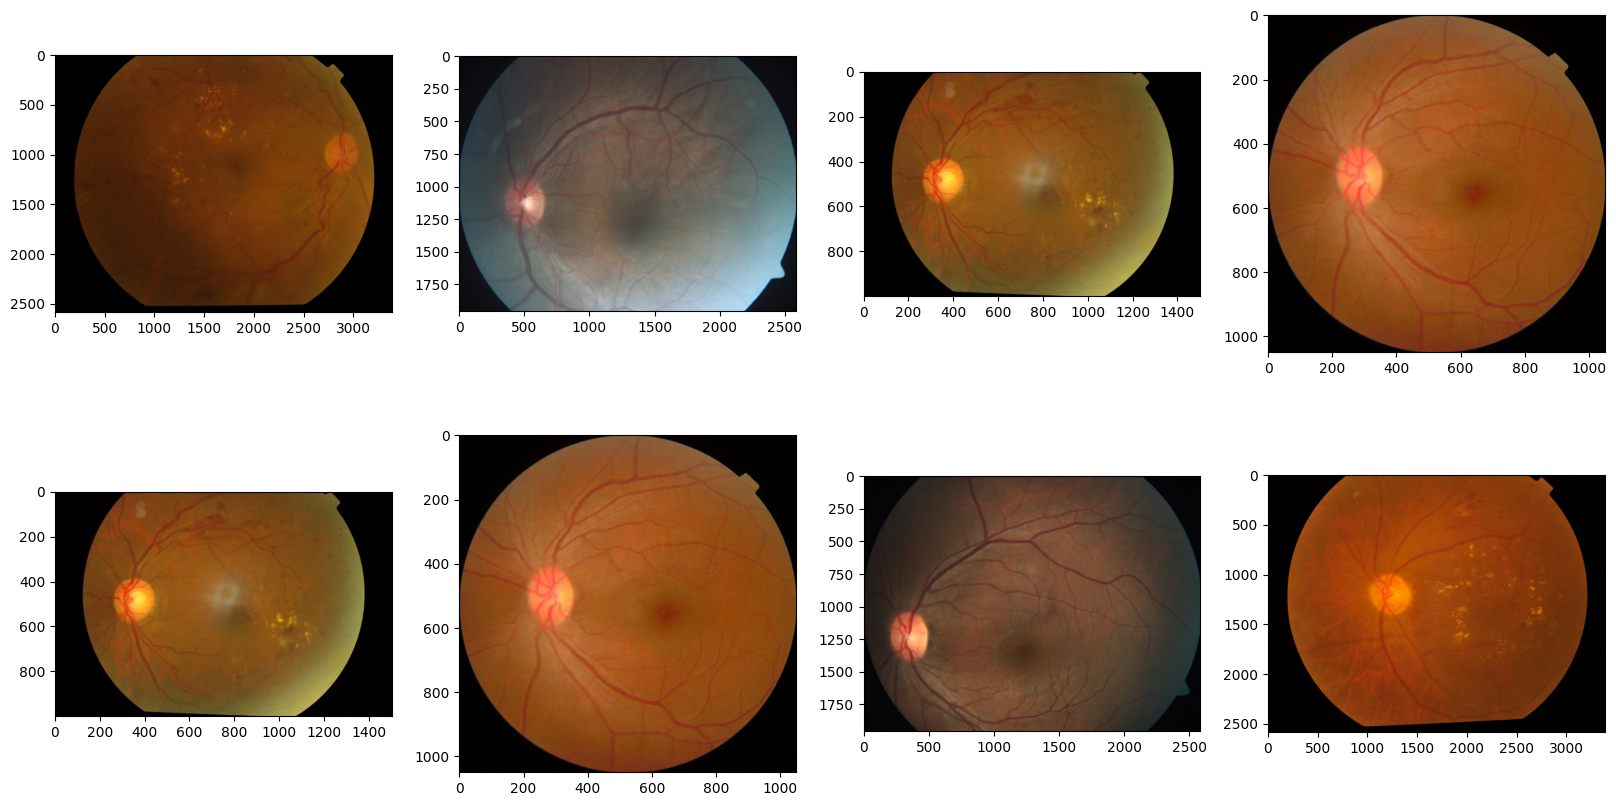

In [3]:
# Read image
indx=0
images = []

print('Sample of images in data:')
for idx, img in enumerate(os.listdir(IMAGE_PATH)):
    img = load_img(
    IMAGE_PATH + img)
    images.append(img)

nrows, ncols = 2,4 # print first 8 images
f, axs = plt.subplots(nrows, ncols, figsize=(20,10))
for i in range(nrows):
    for j in range(ncols):
        indx = i*nrows+j
        axs[i,j].imshow(images[indx])

**`Data Preprocessing`**

The quality of the data determines how well an ML algorithm can learn. We'll apply some simple techniques to deal with class imbalance. We'll then create training/validation/test datasets and perform image transformation and augmentation.

First, we'll graph a histogram for the five classes of DR.

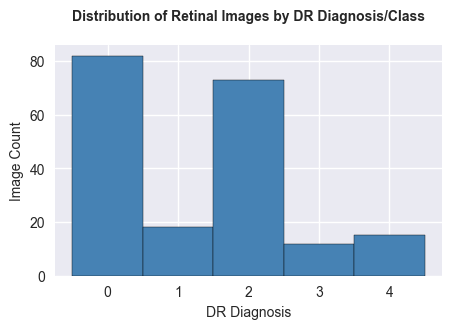

In [4]:
# Set up histogram for five classes (diagnoses) of DR
plt.style.use("seaborn-v0_8")
plt.figure(figsize = (5, 3))
plt.hist(y.diagnosis,
         bins = np.arange(6) - 0.5,
         color = "steelblue",
         edgecolor = "black")
plt.title("Distribution of Retinal Images by DR Diagnosis/Class\n",
          fontsize = 10,
          fontweight = "bold")
plt.xlabel("DR Diagnosis",
           fontsize = 10)
plt.ylabel("Image Count",
           fontsize = 10)

# Display histogram
plt.show()

The largest class is DR Diagnosis label 0, which indicates "No DR." **41% of the images (82 out of 200) have this label of 0.**

**`Correct for Data Imbalance`**

As the histogram shows, our dataset is very imbalanced. This is common in healthcare because some diseases are rare. The presence of imbalanced data hampers the detection of rare events as most classification methods implicitly assume a similar occurrence of classes and are designed to maximize the overall classification accuracy.

We'll correct for class imbalance in two ways:

  * First, we will binarize the DR diagnosis as follows:
     - 'no refer' are {No DR, mild}
     - 'refer' are {Moderate, Severe, Proliferate}

  * Second, we'll only take 80 random samples from the 'no refer' class and 80 from the 'refer' class.

This is a crude method to deal with imbalanced data, but it will be good enough for a quick analysis. 

In [5]:
# Set seed for reproducibility
np.random.seed(1234)

no_refer = y[y.diagnosis.isin((0,1))]
refer = y[y.diagnosis.isin((2,3,4))]

# Randomly draw 80 images from each class
temp_no_refer = list(np.random.choice(
    no_refer.id_code,
    size=80,
    replace=False
))

temp_refer = list(np.random.choice(
    refer.id_code,
    size=80,
    replace=False
))

In [6]:
def preprocess_data_part1(IMAGE_PATH, LABEL_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    LABEL_PATH (str): path to directory with labels.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 224, 224, 3)
    y_mini (np.ndarray): Labels of shape (N,)    
    """
    # Define empty lists for images and labels
    y_mini = []
    images_mini = []

    # Create lists of images and labels based on temp_no_refer/temp_refer selections
    for idx, img in enumerate(os.listdir(IMAGE_PATH)):
        
        # Read labels
        if img.split('.')[0] in temp_no_refer:
                y_mini.append(0)
        elif img.split('.')[0] in temp_refer:
                y_mini.append(1)
        else:
            continue

        # Read image
        img = load_img(
            IMAGE_PATH + img,
            target_size=(224, 224)
        )
        
        # Transform image to array
        img = img_to_array(img)

        # Append to images
        images_mini.append(img)

    # Stack images and trasnform to array
    images_mini = np.stack(images_mini)
    y_mini = np.array(y_mini).flatten()
    
    return images_mini, y_mini

In [7]:
# Generate images and labels based on preprocess_data_part1() function
images_mini, y_mini = preprocess_data_part1(IMAGE_PATH, LABEL_PATH)

print(f"images_mini shape {images_mini.shape}")
print(f"y_mini shape {y_mini.shape}")

images_mini shape (159, 224, 224, 3)
y_mini shape (159,)


**`Create Train/Validation/Test Data and Perform Image Tranformation and Augmentation`**

After we split the data into training, validation, and test sets, we'll apply image transformation and augmentations. We'll start with a simple example applied to the first image in our mini data.

Metal device set to: Apple M2 Pro


2023-02-15 22:25:12.340922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-15 22:25:12.341052: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


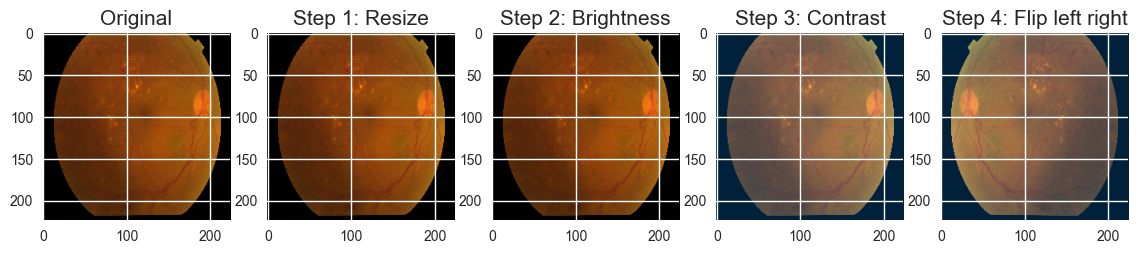

In [8]:
# Set seed for reproducibility
tf.random.set_seed(1234)

# Create figure for plotting images
fig = plt.figure(figsize=(14, 12))

# Pull first image from data
image = images_mini[0]

# Plot original image
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

## Note: The following image transformations/augmentations 'stack' or 'build' on each other sequentially

# Plot resized image
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(image, size=(224, 224))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);

# Plot image with adjusted brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);

# Plot image with adjusted contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);

# Plot image flipped left-right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

Next, we'll define and run a preprocess_data_part2() function to create:

* train/validation/test sets with splits [0.6, 0.2, 0.2]

* image transformations and augmentations, as follows...

    <u>Applied on training, validation, and test sets</u>:
      - resize to IMAGE_SIZE = (224,224) using tf.image.resize()
      - normalize all pixel values to the range (0,1)
  
    <u>Applied on training set only</u> (note that this step will create additional/augmented copies of the
    training data):
      - adjust brightness by adding DELTA = 0.3 to the pixel values using tf.image.adjust_brighness()
      - adjust contrast to CONTRAST_FACTOR = 3 using tf.image.adjust_contrast()
      - flip left right using tf.image.flip_left_right()

The quantity and diversity of data gathered have a significant impact on the results of a CNN model. We can apply augmentations to artificially inflate the training dataset by warping the original data such that their label does not change. These augmentations can significantly improve learning results without collecting new data.

In [9]:
IMAGE_SIZE = (224, 224)
CONTRAST_FACTOR = 3      ### ADJUST CONTRAST HERE FOR EXPERIMENTATION
DELTA = 0.3              ### ADJUST BRIGHTNESS HERE FOR EXPERIMENTATION

def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; apply transformaions and augmentations
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 3)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 3)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 3)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    
    ### Create train/validation/test sets ###
    #########################################
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images, y = images[shuffle], y[shuffle]
    
    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images_mini, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y_mini, [splits[0], splits[0]+splits[1]])
    
    ### Image transformation on training, validation, and test data ###
    ###################################################################
    # Image resize
    X_train = tf.image.resize(X_train, size=IMAGE_SIZE)
    X_val = tf.image.resize(X_val, size=IMAGE_SIZE)
    X_test = tf.image.resize(X_test, size=IMAGE_SIZE)
    
    # Rescale image to [0,1] (i.e., grayscale)
    X_train = X_train/255.0
    X_val = X_val/255.0
    X_test = X_test/255.0
    
    
    ### Image augmentation on training data ###
    ###########################################
    # Adjust brightness
    X_train_augm = tf.image.adjust_brightness(X_train, delta=DELTA)
    
    # Adjust contrast
    X_train_augm = tf.image.adjust_contrast(X_train_augm, contrast_factor=CONTRAST_FACTOR)

    # Random flip
    X_train_augm = tf.image.random_flip_left_right(X_train_augm) ### ADJUST FLIP HERE FOR EXPERIMENTATION
    
    # Concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)
    
    # Concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)
    
    # Shuffle X_train and y_train (i.e., shuffle two tensors in the same order)
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() # also transforms y_train to numpy array
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (190, 224, 224, 3)
y_train shape (190,)
X_val shape (31, 224, 224, 3)
y_val shape (31,)
X_test shape (33, 224, 224, 3)
y_test shape (33,)


We'll print out the first 8 train and validation examples with the label of each example as the title.

Print training data examples:


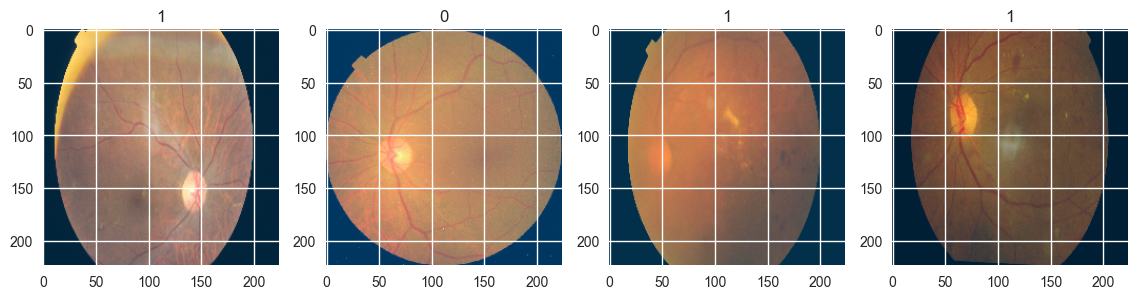

In [11]:
# Print taining data
print('Print training data examples:')
nrows, ncols = 1,4 # print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_train[i]))
    axs[i].set(title=y_train[i])

Print validation data examples:


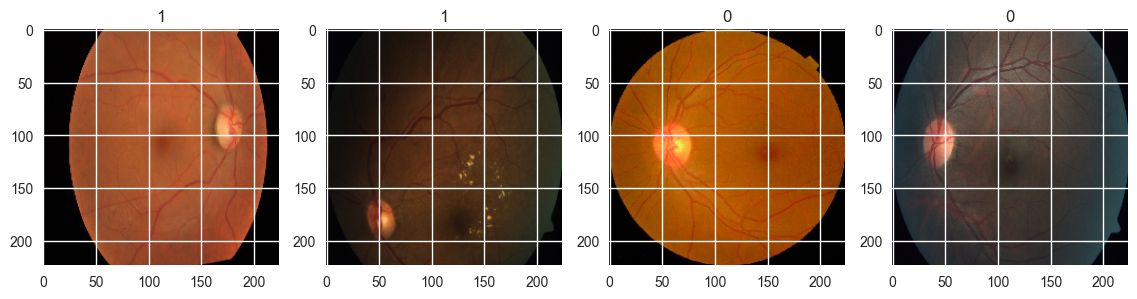

In [12]:
# Print test data
print('Print validation data examples:')
nrows, ncols = 1,4 # print first 4 images
f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
for i in range(ncols):
    axs[i].imshow(array_to_img(X_val[i]))
    axs[i].set(title=y_val[i])

**`Build/Train CNN Model`**

Our objective is to build and train a CNN model to refer patients to doctors based on the severity of DR seen in these images. We're interested in exploring binary classification of 'no refer' and 'refer'.

<u>The architecture of our CNN model is as follows</u>:

1. the model receives input images of size 224 x 224 x 3 (the images have three color channels)
2. the input data goes through two convolutional layers that have kernels of size 5 x 5
3. the first convolution has 32 output feature maps, and the second one has 64
4. each convolution layer is followed by a max-pooling layer (this will reduce the size of the feature maps)
5. the last two layers of the model are fully connected with a droput layer in between

For each convolution, we'll use strides=(1,1) to preserve the dimension of the inputs in the resulting feature maps. For the pooling layers, we'll set strides=(2,2) to subsample the image and shrink the size of the output feature maps. For the dropout layer, we'll set the probability of dropping input units during training to 0.5.

In [13]:
# Build model
model = tf.keras.Sequential()

# Add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5), ### ADJUST KERNEL SIZE HERE FOR EXPERIMENTATION
    strides=(1, 1),     ### ADJUST STRIDES HERE FOR EXPERIMENTATION
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# Add max pooling layer with pool size (2,2) and strides of 2 to reduce spatial dimensions by half
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),   ### ADJUST POOL SIZE HERE FOR EXPERIMENTATION
    name='pool_1'))


# Add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5), ### ADJUST KERNEL SIZE HERE FOR EXPERIMENTATION
    strides=(1, 1),     ### ADJUST STRIDES HERE FOR EXPERIMENTATION
    padding='same',
    name='conv_2',
    activation='relu'))

# Add max pooling layer with pool size (2,2) and strides of 2 to further reduce spatial dimensions by half
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),   ### ADJUST POOL SIZE HERE FOR EXPERIMENTATION
    name='pool_2')
)

# Add fully connected layer
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# Add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# Add last fully connected layer
# Note: this layer sets the activation function to "None" in order to output the logits
model.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation=None))

# Build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 224, 224, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 pool_1 (MaxPooling2D)       (None, 112, 112, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 112, 112, 64)      51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 56, 56, 64)        0         
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 fc_1 (Dense)                (None, 1024)              205521920 
                                                                 
 dropout (Dropout)           (None, 1024)              0

Next, we'll define the type of optimizer, loss function, and metrics to compute and then compile the model.

For this analysis, we'll use the Adam optimizer, binary cross-entropy for loss, and compute model accuracy on the training, validation, and test datasets.

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(), ### ADJUST LEARNING RATE/OPTIMIZER HERE FOR EXPERIMENTATION
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), # set from_ligits=True because our last layer does not apply sigmoid
              metrics=['accuracy']) 

**``Fit CNN Model``**

Now we'll fit the model with 10 epochs on the training set and validate on the validation set. Its performance will obviously depend on hyperparameters like learning rate and optimizer.

In [15]:
# Set random seed for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, y_train,
                    epochs=10, 
                    validation_data=(X_val, y_val))

Epoch 1/10


2023-02-15 22:25:13.577773: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-15 22:25:13.759047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 2s 266ms/step - loss: 11.3510 - accuracy: 0.5105 - val_loss: 0.5993 - val_accuracy: 0.7742
Epoch 2/10


2023-02-15 22:25:15.330231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 245ms/step - loss: 0.4499 - accuracy: 0.7789 - val_loss: 0.5425 - val_accuracy: 0.8065
Epoch 3/10
6/6 [==============================] - 1s 251ms/step - loss: 0.4194 - accuracy: 0.8211 - val_loss: 0.4114 - val_accuracy: 0.8065
Epoch 4/10
6/6 [==============================] - 1s 242ms/step - loss: 0.3499 - accuracy: 0.8368 - val_loss: 0.4388 - val_accuracy: 0.8387
Epoch 5/10
6/6 [==============================] - 1s 244ms/step - loss: 0.2693 - accuracy: 0.8789 - val_loss: 0.6897 - val_accuracy: 0.8065
Epoch 6/10
6/6 [==============================] - 1s 247ms/step - loss: 0.2830 - accuracy: 0.8368 - val_loss: 0.4478 - val_accuracy: 0.8065
Epoch 7/10
6/6 [==============================] - 1s 246ms/step - loss: 0.2489 - accuracy: 0.8632 - val_loss: 0.4422 - val_accuracy: 0.8065
Epoch 8/10
6/6 [==============================] - 1s 241ms/step - loss: 0.2532 - accuracy: 0.8684 - val_loss: 0.4425 - val_accuracy: 0.8065
Epoch 9/10
6/6 [===============

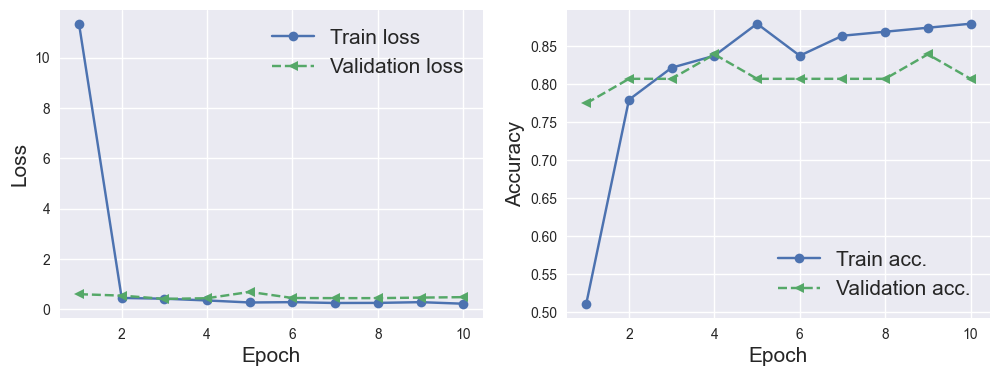

In [16]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

**`CNN Model Learning by Layer`**

We'll pick one example from our training data to visualize our CNN model's learning after each layer. Below, we print the original image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape of image: (1, 224, 224, 3)


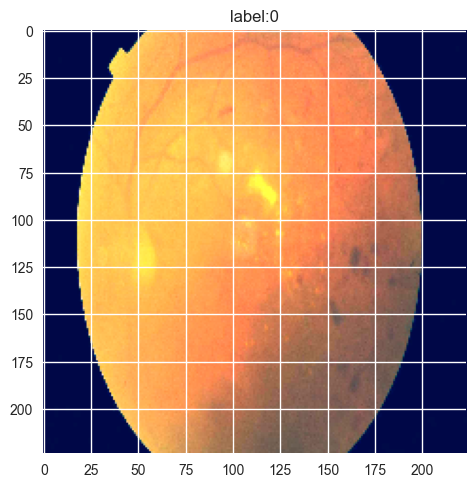

In [17]:
img_tensor = np.expand_dims(X_train[2], axis = 0);

# Print image tensor shape
print('Shape of image:', img_tensor.shape);
  
# Print image
plt.imshow(img_tensor[0]);
plt.title('label:' + str(y_train[1]))
plt.show()

1/1 [==============================] - 0s 44ms/step
----------------
Geeting activations of layer 1 : conv_1
Images size is 224 x 224
Number of channels is 32
Printing channels:


2023-02-15 22:25:28.998956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


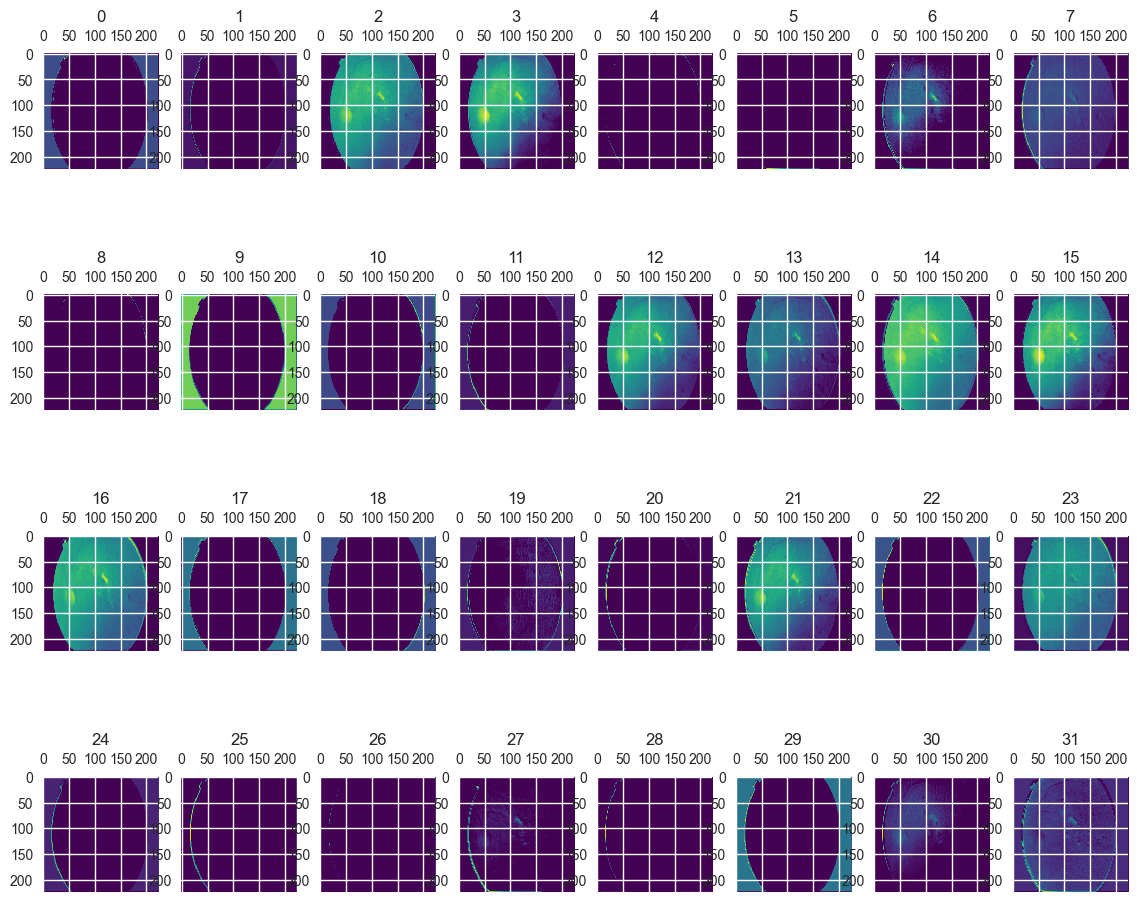

----------------
Geeting activations of layer 2 : pool_1
Images size is 112 x 112
Number of channels is 32
Printing channels:


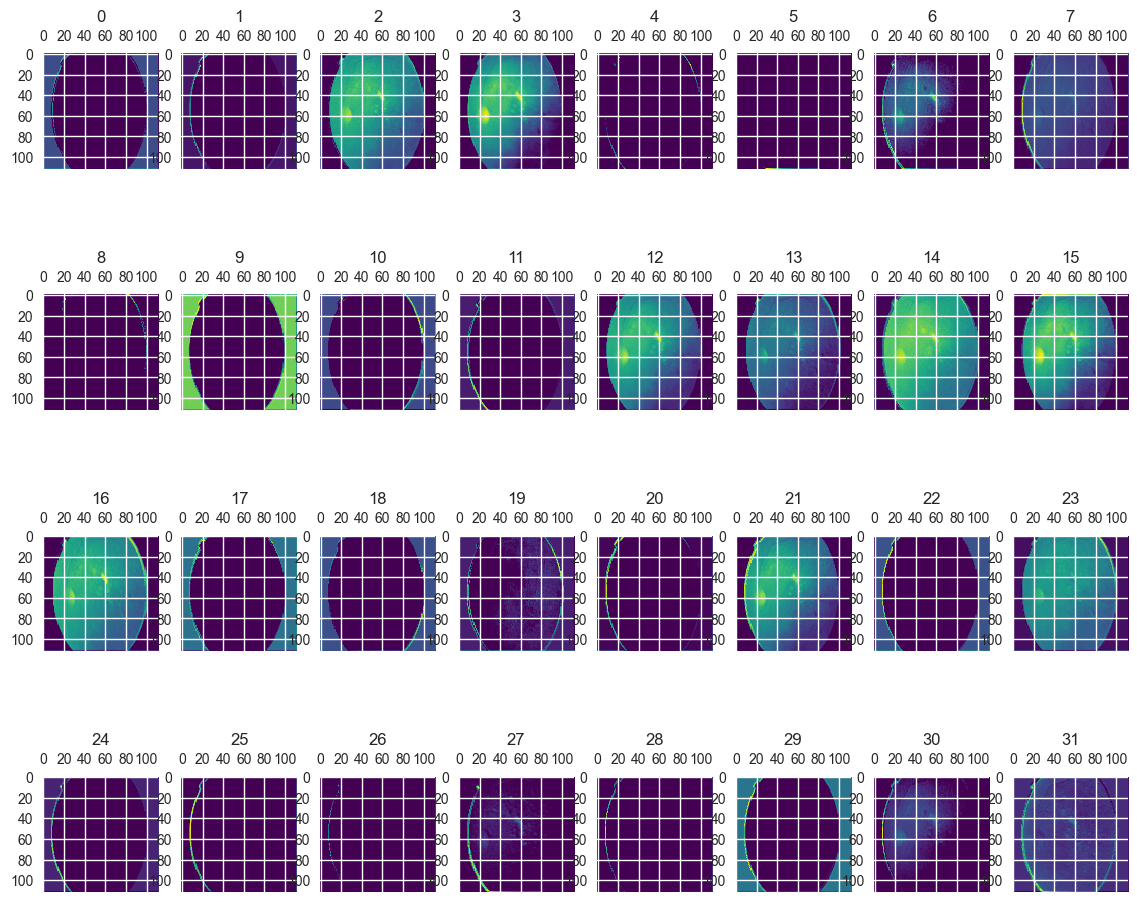

----------------
Geeting activations of layer 3 : conv_2
Images size is 112 x 112
Number of channels is 64
Printing channels:


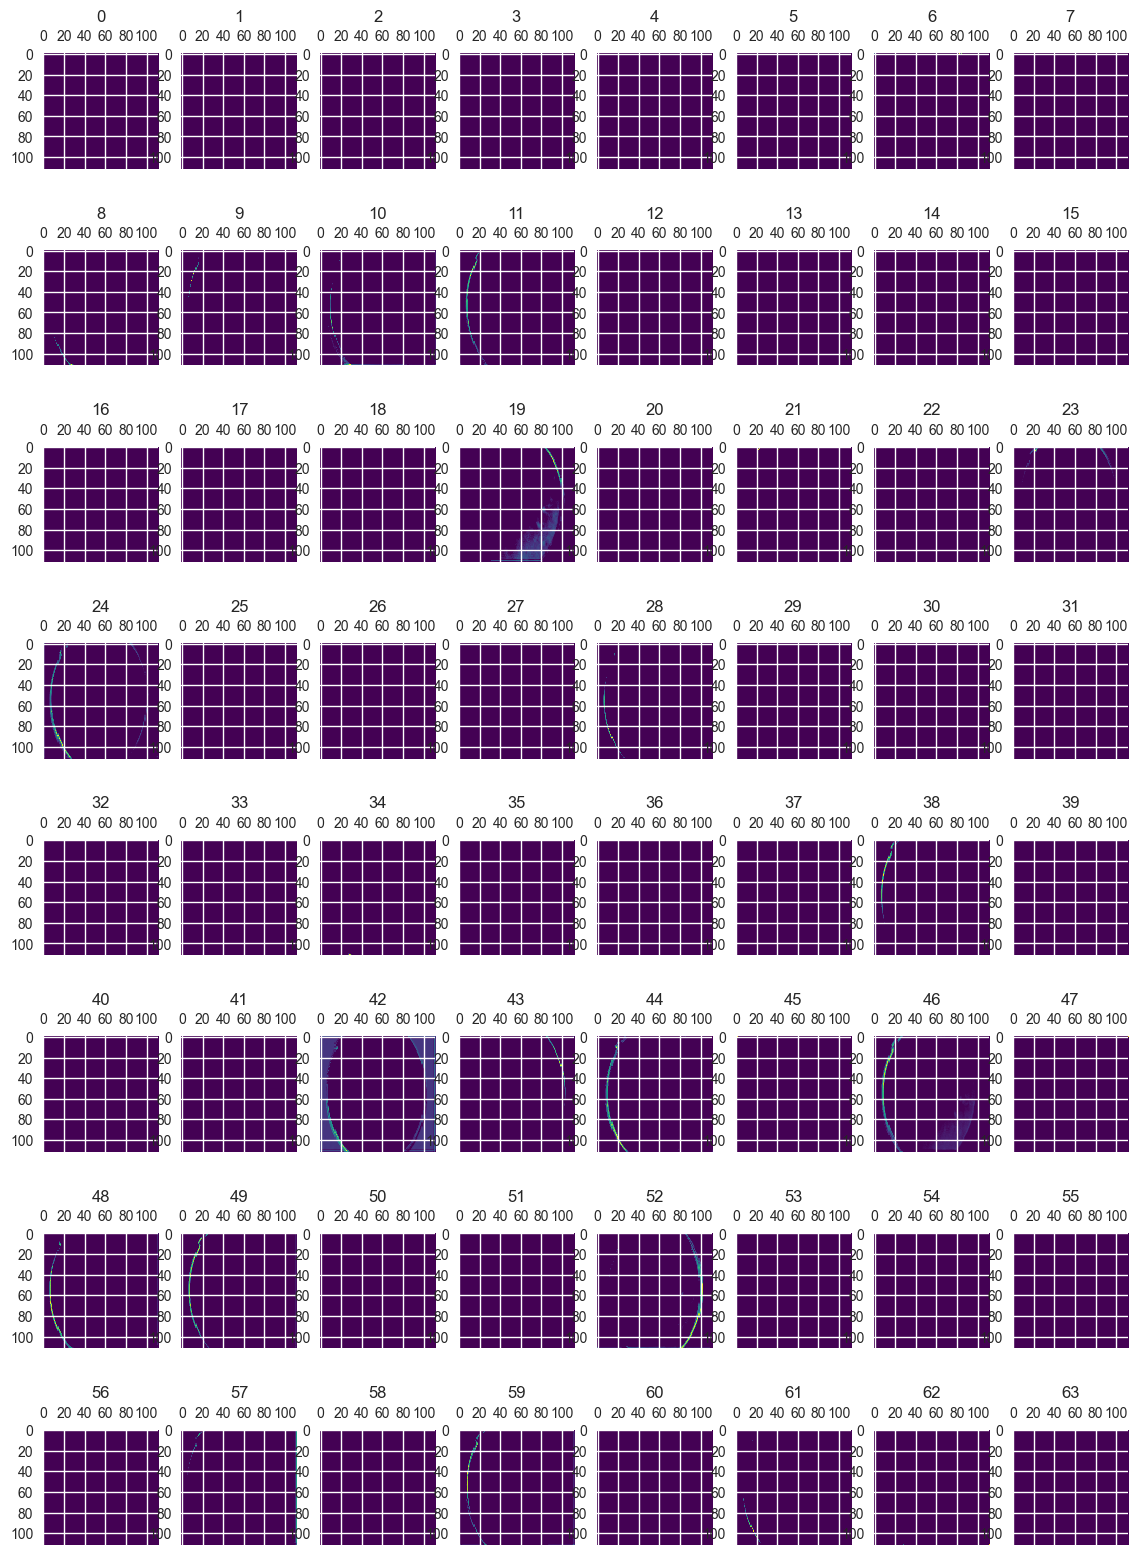

----------------
Geeting activations of layer 4 : pool_2
Images size is 56 x 56
Number of channels is 64
Printing channels:


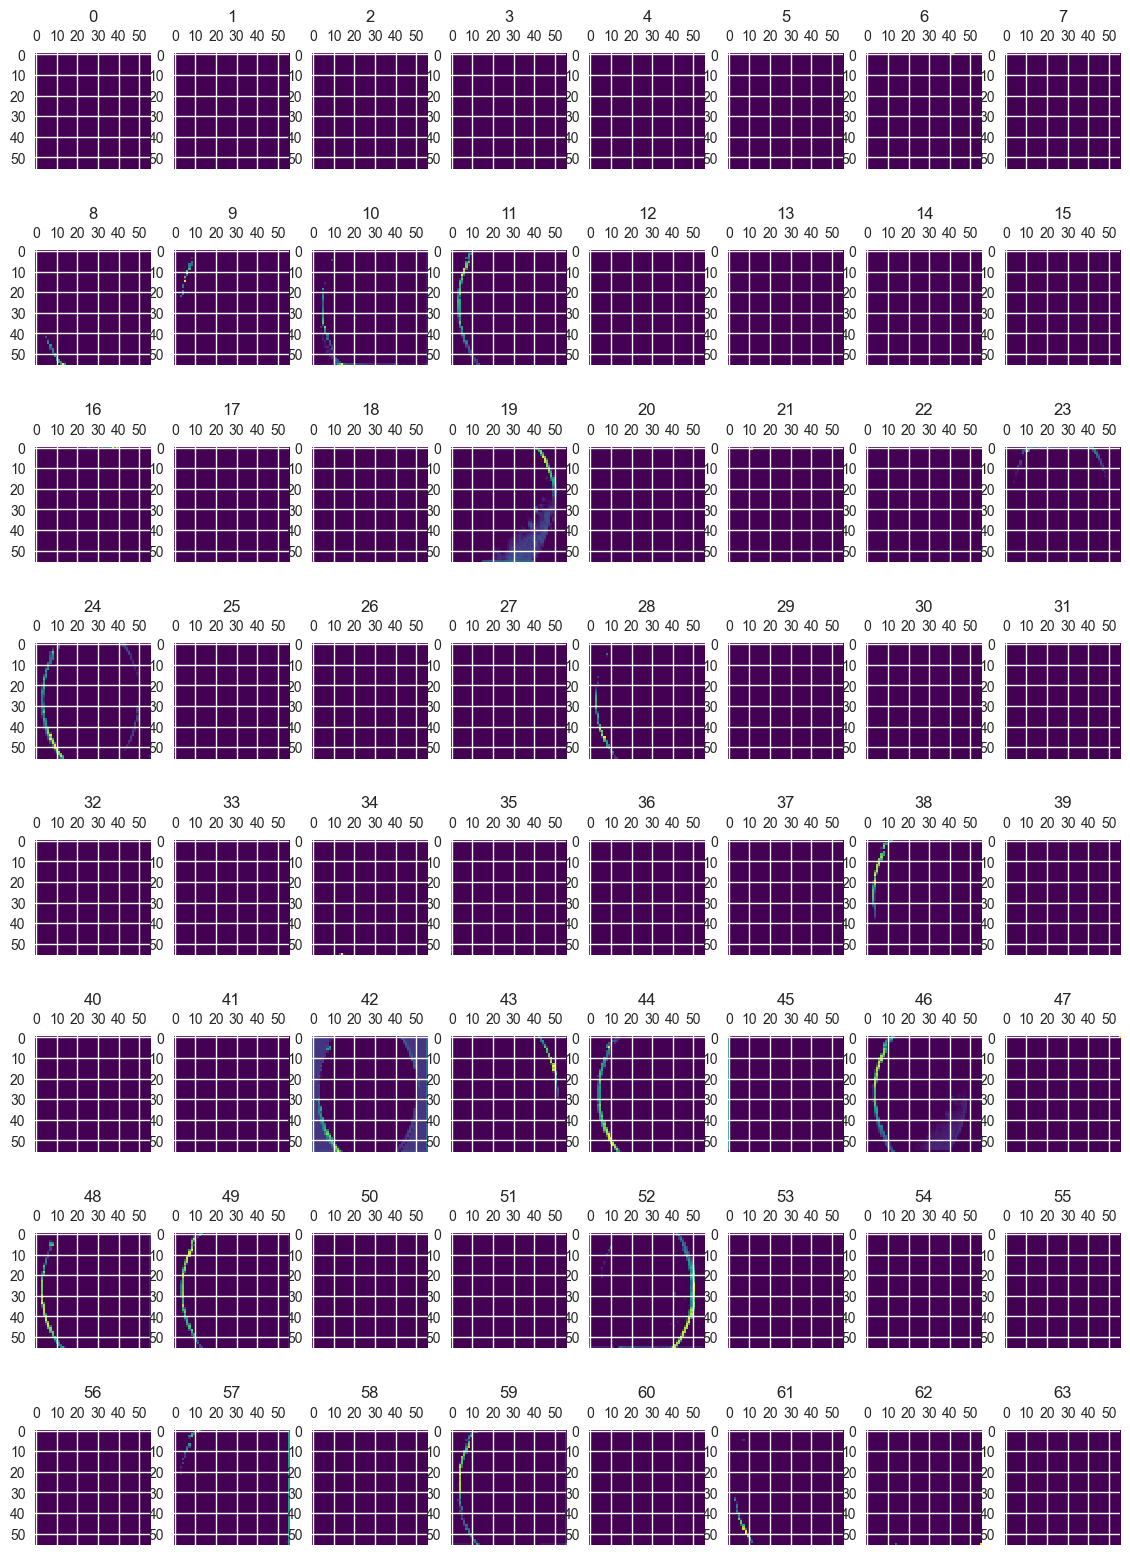

In [18]:
# Outputs of the first 4 layers, which include conv2D and max pooling layers
layer_outputs = [layer.output for layer in model.layers[:4]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)
activations = activation_model.predict(img_tensor)

# Grab layer names
layer_names = []
for layer in model.layers[:4]:
    layer_names.append(layer.name)

# Get activations of each layer
for idx, layer in enumerate(activations):
    if idx in (0,1,2,3):
        print('----------------')
        print('Geeting activations of layer',  idx+1, ':', layer_names[idx])
        activation = layer

        # Shape of layer activation
        print('Images size is', activation.shape[1], 'x', activation.shape[2])
        print('Number of channels is', activation.shape[3])

        # Print channels
        print('Printing channels:')
        
        # Define nrows and ncols depending on number of channels
        if idx in (0,1):
            nrows, ncols = 4,8
        if idx in (2,3):
            nrows, ncols = 8,8

        # Plots
        channel=0
        if idx in (0,1):
            f, axs = plt.subplots(nrows, ncols, figsize=(14,12))
        if idx in (2,3):
            f, axs = plt.subplots(nrows, ncols, figsize=(14,20))
            
        for i in range(nrows):
            for j in range(ncols):
                if i==0 and j==0:
                    channel=0
                else:
                    channel+=1

                axs[i,j].matshow(activation[0,:, :, channel], cmap ='viridis')
                axs[i,j].set(title=str(channel))
        plt.show()

Initial layers appear to be more interpretable and retain the majority of the features in the input image. As the level of the layer increases, features become less interpretable; they become more abstract and they identify features specific to the class, leaving behind the general features of the image.

**`Evaluate CNN Model`**

We'll use our test data to evaluate the performance (accuracy) of our CNN model on unseen data.

In [19]:
test_results = model.evaluate(X_test, y_test)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

2/2 [==============================] - 0s 55ms/step - loss: 0.4232 - accuracy: 0.8182

Test Acc. 81.82%


In the following figure, we can see all the images in the test data along with their ground truth (GT) labels and the predicted probabiliy that they belong to class 1 ('Refer').

In [20]:
# Transform logits to probabilities
pred_logits = model.predict(X_test)
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten()*100

2/2 [==============================] - 0s 89ms/step


2023-02-15 22:25:37.377688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


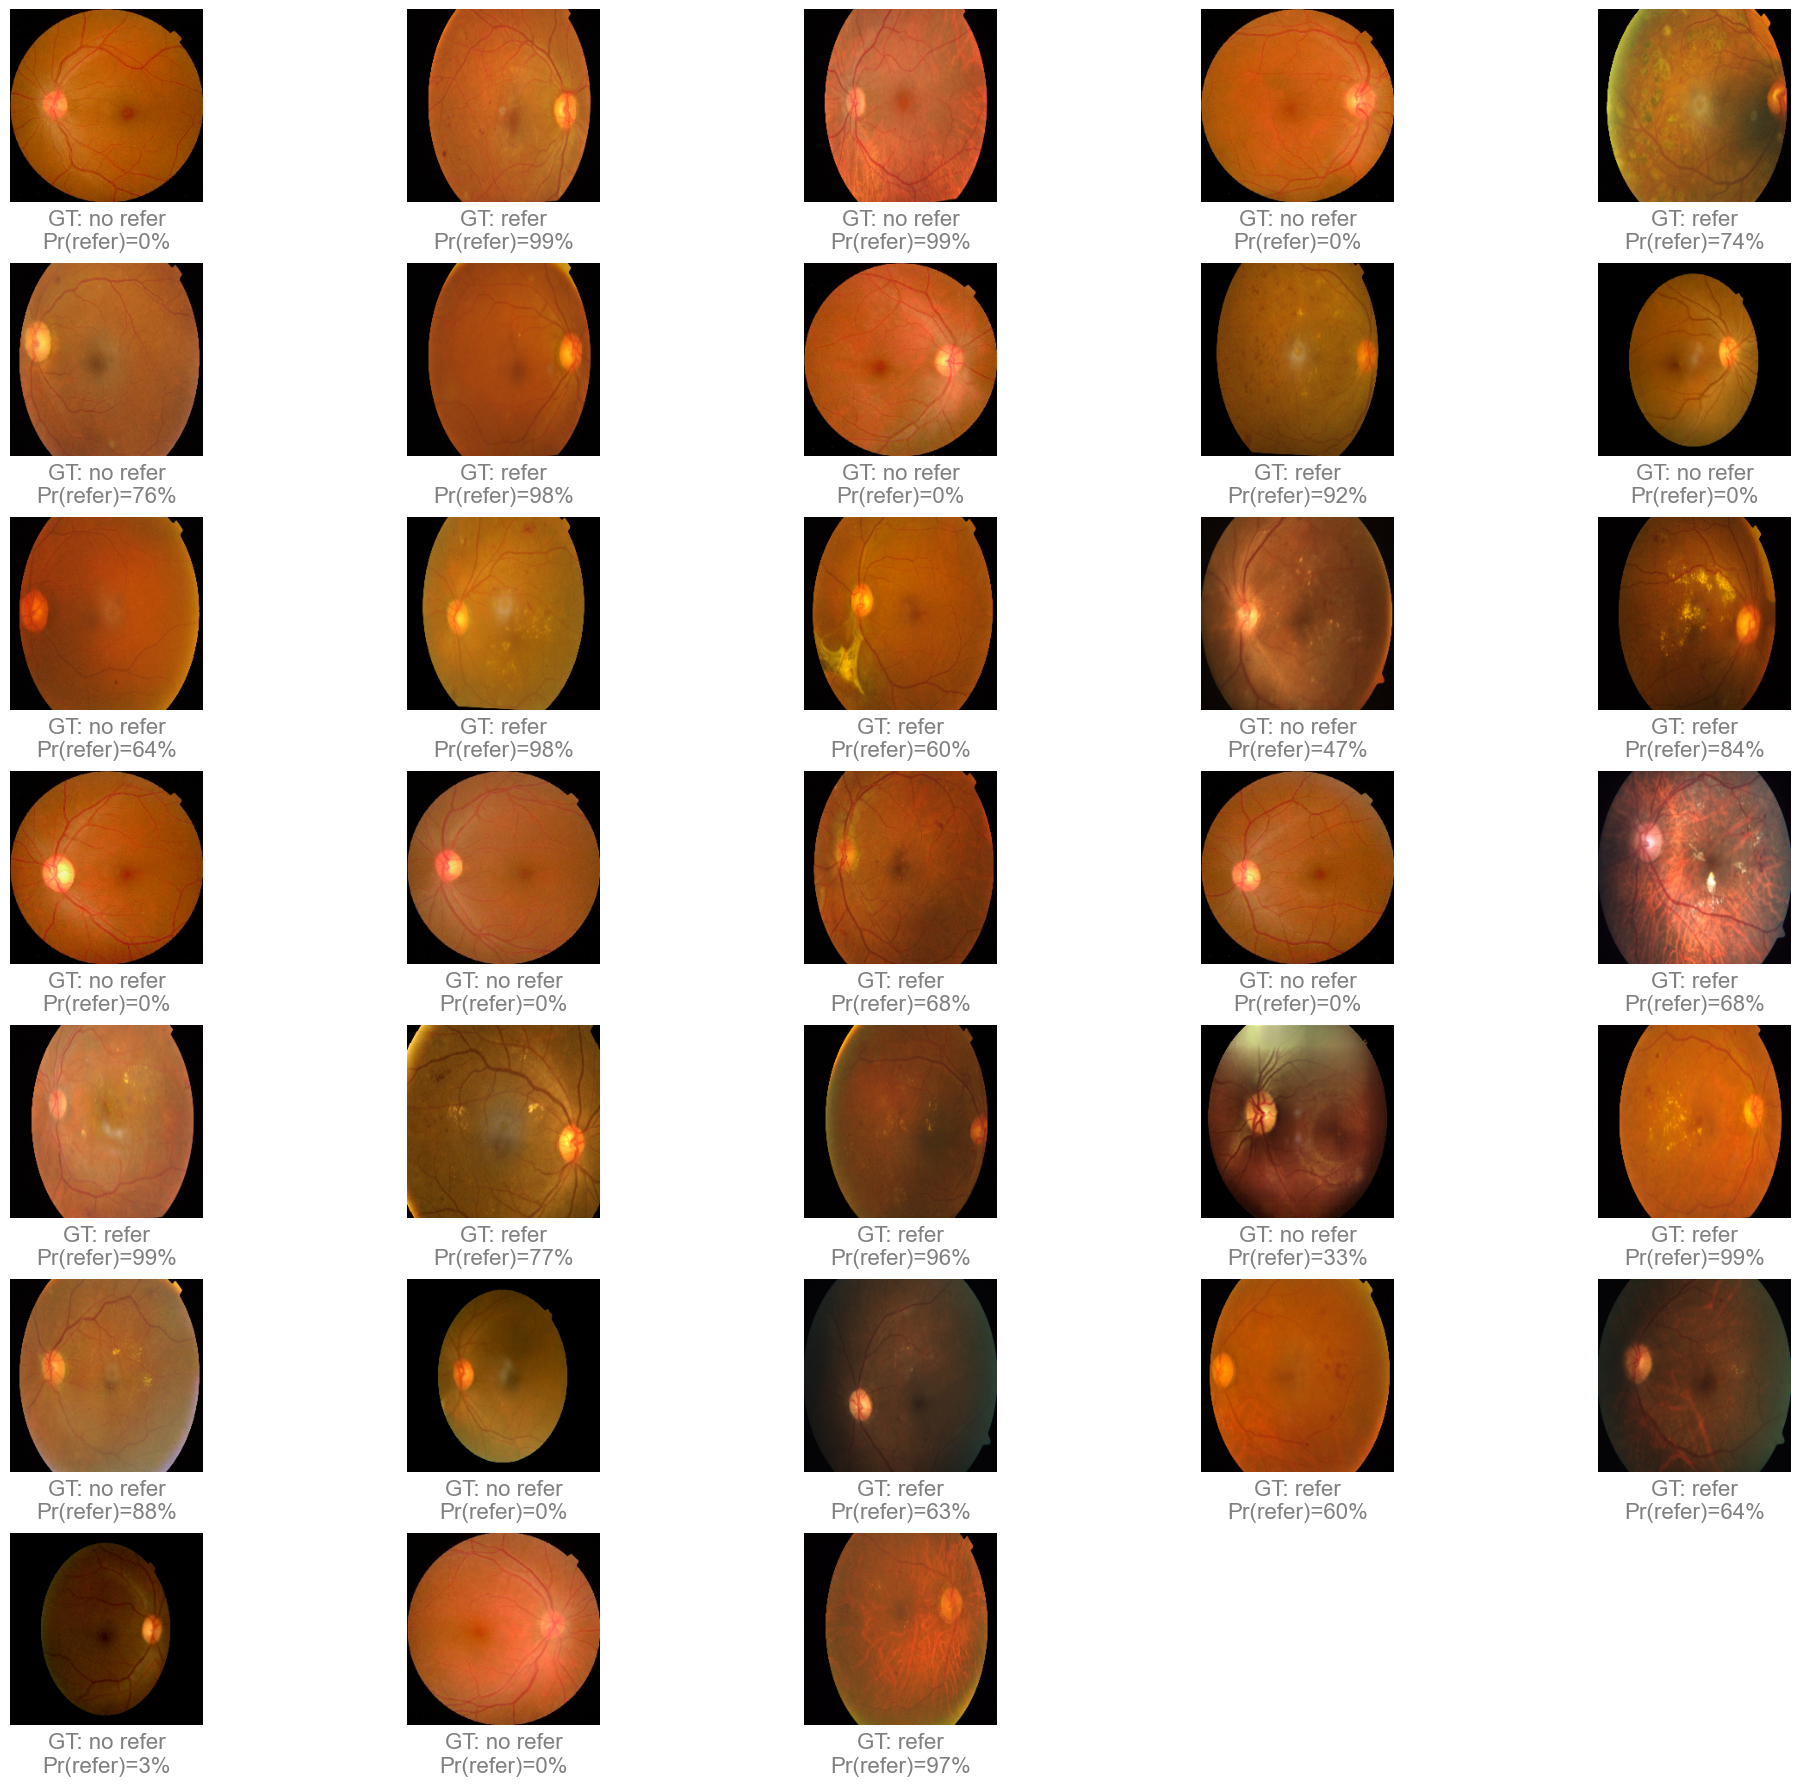

In [21]:
# Plot test data and associated predicted class
fig = plt.figure(figsize=(20, 20))

for j, example in enumerate(X_test):
    ax = fig.add_subplot(8,5, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(array_to_img(example))
    if y_test[j]==0:
        label='no refer'
    else:
        label='refer'
    
    ax.text(
        0.5, -0.15, 
        'GT: {:s}\nPr(refer)={:.0f}%'.format(label, probas[j]), 
        size=16, 
        color='grey',
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes)
    
plt.tight_layout()
plt.show()

We'll end by experimenting with different hyperparameter values to see how sensitive the accuracy of our CNN model is. We'll document results by filling out the table below.

For experimentation, we'll change one hyperparameter value at a time, as follows: 

* kernel size = 3 x 3
* strides = 2 x 2
* pool size = 3 x 3
* learning rate = 0.01
* optimizer = 'SGD'
* image augmentation applied on the training data: (brightness (delta) = 0.1, contrast = 2, flip = no)

| Trining accuracy | Validation accuracy |  kernel size |  strides | pool size  |  learning rate | optimizer  | brightness (delta) |  contrast factor | flip_on_train  |
|:-:                |:-:                  |:-:           |:-:       |:-:         |:-:             |:-:         |:-:                 |:-:               |:-:             |
| 0.94              | 0.81                | 5,5          | 1,1      | 2,2        | 0.001          | Adam       | 0.3                | 3                | yes            |
| 0.95               | 0.84                 | <font color="red">3,3</font>     | 1,1      | 2,2        | 0.001          | Adam       | 0.3                | 3                | yes            |
| 0.89               | 0.77                 | 5,5          | <font color="red">2,2</font>  | 2,2        | 0.001          | Adam       | 0.3                | 3                | yes            |
| 0.90               | 0.81                 | 5,5          | 1,1      | <font color="red">3,3</font>   | 0.001          | Adam       | 0.3                | 3                | yes            |
| 0.83               | 0.74                 | 5,5          | 1,1      | 2,2        | <font color="red">0.01</font>       | Adam       | 0.3                | 3                | yes            |
| 0.88               | 0.74                 | 5,5          | 1,1      | 2,2        | 0.001          |<font color="red">SGD</font>     | 0.3                | 3                | yes            |
| 0.93               | 0.81                 | 5,5          | 1,1      | 2,2        | 0.001          | Adam       | <font color="red">0.1</font>            | 3                | yes            |
| 0.91               | 0.84                 | 5,5          | 1,1      | 2,2        | 0.001          | Adam       | 0.3                | <font color="red">2</font>            | yes            |
| 0.93               | 0.81                 | 5,5          | 1,1      | 2,2        | 0.001          | Adam       | 0.3                | 3                | <font color="red">no</font>         |


Based *only on these tested scenarios*, I'm most satisfied with the second to last CNN model specification in the table where we **adjusted the contrast to 2** in the image augmentation applied on the training data and left all other hyperparameters the same. The primary reason I'm choosing this model specification is because it achieves >90% accuracy on the training set and also minimizes the difference between the training and validation accuracies at ~ 91% and ~ 84%, respectively (~ 7 percentage points). This result suggests that it may do better than some of the other model specifications at generalizing to new/unseen data and avoids overfitting to the training data.

For this specification, the accuracy of the model on the test set is **~ 75.8%**. While this value is about 15 percentage points lower than the accuracy of the training set, it isn't abysmal. However, if I were to expand this notebook or run this analysis in a "real-world" situation, I would want to make sure I had an appropriate baseline to compare this accuracy value to (along with the accuracy value for my training set) so that I could reasonably evaluate how good/bad it actually is. I'd also want to take some time to try out *additional* adjustments to the model specifications –– outside of just the ones listed in the table above –– to look for potential performance-boosting scenarios where a few adjustments are considered/interacted simultaneously. For example, adjusting the kernel size to [3, 3], the pool size to [3, 3], and the contrast to 2 appears to produce a training set accuracy of ~ 94.2%, a validation set accuracy of ~ 87.1%, and a test set accuracy of ~ 78.8%. This additional specification maintains a low degree of separation between training and validation accuracies –– approximately 7 percentage points –– and also achieves a higher test accuracy than the model specification where we only adjusted the contrast to 2, suggesting it would yield an even better CNN model.